# El problema de la mochila

Se tiene una mochila y un conjunto de artículos con diferente peso y valor. Se intenta determinar que artículos se pueden colocar adentro de la mochila de manera que no se sobrepase el límite de peso de la mochila maximizando el valor total. 

Resolver el problema agregando heurística para los siguientes artículos y un límite de 30kg:

<table style="font-size:16px">
    <tr>
        <th>Item</th><td>Valor</td><td>Peso</td>
    </tr>
    <tr>
        <th>A</th><td>4</td><td>12</td>
    </tr>
    <tr>
        <th>B</th><td>2</td><td>2</td>
    </tr>
    <tr>
        <th>C</th><td>10</td><td>4</td>
    </tr>
    <tr>
        <th>D</th><td>1</td><td>1</td>
    </tr>
    <tr>
        <th>E</th><td>5</td><td>15</td>
    </tr>
    <tr>
        <th>F</th><td>3</td><td>2</td>
    </tr>
    <tr>
        <th>G</th><td>14</td><td>7</td>
    </tr>
    <tr>
        <th>H</th><td>4</td><td>10</td>
    </tr>
</table>

## Codificación

- Definir como se codificará el problema

#### Maximizar valor: Z = 4A + 2B + 10C + 1D + 5E + 3F + 14G + 4H
#### Restricción peso:  12A + 2B + 4C + 1D + 15E + 2F + 7G + 10H  <=  30

En este problema tenemos 8 variables, por lo que el cromosoma tendrá 8 genes

In [1]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from toolz import unique

## Adaptación

- Definir como se calculará la adaptación de un individuo

La función adaptación será  la fórmula del Valor, que se trata de maximizar. A mayor Valor mejor adaptación.
- ¿Existen estados que deben ser penalizados?

Deberían penalizarse los que no respeten la restricción de no superar los 30 kilos.

In [2]:
def adaptation_function(population):
    fitness = []
    i = 0
    bests = []
    for pop in population:
        peso = ((pop[0] * 12) + (pop[1] * 2) + (pop[2] * 4) + (pop[3]) + (pop[4] * 15) + (pop[5] * 2) + (pop[6] * 7) + (pop[7] * 10))
        #print(f'peso: {peso}')
        if peso <= 30:
            fitness.append( ( (pop[0] * 4) + (pop[1] * 2) + (pop[2] * 10) + (pop[3]) + (pop[4] * 5) + (pop[5] * 3) + (pop[6] * 14) + (pop[7] * 4)) )
        else:
            # si supera el peso, se aplica penalización de "Sentencia de Muerte"
            # y directamente se establece un fitness de 0 al individuo
            fitness.append(0)
    for pop in population:
        if fitness[i] == max(fitness):
            bests.append(pop)
        i = i+1
    #print(f'lista-fitness {fitness} end-fitness')
    return fitness, bests

## Selección

In [3]:
# Recibe la lista con los entrenamientos de cada hijo y los ordena con numeros enteros ej: [1,2,3,4,5,6] 
# basandose en el valor que se obtuvo en la adaptacion.
def rank(fitness):
    array = np.array(fitness)
    temp = array.argsort()
    return (np.arange(len(array))[temp.argsort()]).tolist()


# Calculamos la probabilidad que tiene cada hijo usando "SELECCION BASADA EN RANKING".
def probability(population, fitness):
    probability_list = []
    ranking = rank(fitness)
    #print(f'ranking list?: {ranking} end-ranking {len(ranking)}')
    for i in range(len(population)):
        probability_list.append(
            ((ranking[i]) / sum(ranking))
        )
        # acá se puede insertar otra funcion de penalizacion tipo "Stochastic Ranking"
        # donde reste puntos a la Probabilidad del individuo
        # pero cuantos puntos restamos? 0,1 - 0,001 ... debe ser proporcional al valor del resto
    return probability_list


# Seleccionamos el/los padres de la lista de la poblacion, basandonos en la probabilidad de cada individuo.
def select_parents(parents_num, population_len, probability_list):
    # population, weights = probability_list, k = parents_num
    population_aux = range(population_len)
    #print(f'probability list: {probability_list} end-list {len(probability_list)}')
    # a random.choice() le pasamos la lista de padres y su probabilidad de ser seleccionados
    parent_indexs = np.random.choice(population_aux,size=parents_num, replace=False, p=probability_list)
    return [population[i] for i in parent_indexs]



## Cruza

In [4]:
def crossover(parents):
    parents = np.array(parents)
    # Genero arreglo vacío donde se guardarán los hijos
    childrens = np.empty((len(parents),parents.shape[1]))
    # Definio el punto de cruce en la mitad de los padre
    crossover_point = np.uint8(parents.shape[0]/2)
    #print(f'crossover point: {crossover_point} end-cross-point')
    for k in range(len(parents)):
        # Índice del primer padre para realizar la cruza
        parent1_idx = k%parents.shape[0]
        # Índice del segundo padre para realizar la cruza
        parent2_idx = (k+1)%parents.shape[0]
        # Generar el primer hijo con la primer mitad de un padre y la segunda de otro
        childrens[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # Generar el segundo hijo con las partes opuestas
        childrens[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    #Devolver lista de hijos
    return childrens

## Mutación

In [5]:
def mutation(childrens):
    for i, children in enumerate(childrens):
        cont = 0
        # cada hijo muta 2 veces
        for cont in range(4):
            random_index = random.choice(range(8)) #elije un numero random entre 0 y 7
            if childrens[i][random_index] > 0:
                # si es mayor que 0, puede restarle 1 o sumarle 1 o no hacer nada (sumarle 0)
                childrens[i][random_index] = (childrens[i][random_index] + random.randrange(-1, 1))
            else:
                # si el valor del gen es 0, solo puede sumarle 1 o 0
                childrens[i][random_index] = (childrens[i][random_index] + random.randrange(0, 1))
    return childrens

# Algoritmo

In [30]:
def create_population():
    population = []
    amount_population = 100  # la cantidad de iteraciones/alternativas habrá

    # acá se determina un rango para las variables, o sea, cuántos items por tipo irán en la mochila
    # y como la mochila tiene un espacio finito y pequeño, 
    # el rango de cada item se ha limitado según su peso
    for _ in range(amount_population):
        a = random.randrange(0, 2)
        b = random.randrange(0, 15)
        c = random.randrange(0, 7)
        d = random.randrange(0, 30)
        e = random.randrange(0, 2)
        f = random.randrange(0, 15)
        g = random.randrange(0, 4)
        h = random.randrange(0, 3)

        #peso = ((pop[0] * 12) + (pop[1] * 2) + (pop[2] * 4) + (pop[3] * 1) + (pop[4] * 15) + (pop[5] * 2) + (pop[6] * 7) + (pop[7] * 10))
        #peso = ((a * 12) + (b * 2) + (c * 4) + (d * 1) + (e * 15) + (f * 2) + (g * 7) + (h * 10))
        #if peso <= 30:
        population.append([a, b, c, d, e, f, g, h])
        
    return population

if __name__ == "__main__":
    
    population = create_population()
    population_len = len(population)
    #print(f'La poblacion es: {population} end-poblacion')
    
    best_adaptation = list()
    best_solution = list()
    generation = list()
   
    cant_generations = 50
    # en este for se repite el proceso para cada generación, en este caso son 200 generaciones
    for i in range(cant_generations):
        fitness, best_sol = adaptation_function(population)
        
        probability_list = probability(population, fitness)
        #print(probability_list)
        selected_parents = select_parents(population_len // 2, population_len, probability_list)
        #print(selected_parents)
        childrens = crossover(selected_parents)
        #print(childrens)
        childrens = mutation(childrens)
        #print(childrens)
        selected_parents.extend(childrens.tolist())
        new_population = selected_parents
        #print(new_population)
        population_len = len(new_population)
        population = new_population
        best_adaptation.append(max(fitness))
        generation.append(i)
        
    final_best_sol = map(list, unique(map(tuple, best_sol)))
    print(f'Ultima solucion con mejor adaptacion: {list(final_best_sol)}')

Ultima solucion con mejor adaptacion: [[0.0, 5.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


## Grafico

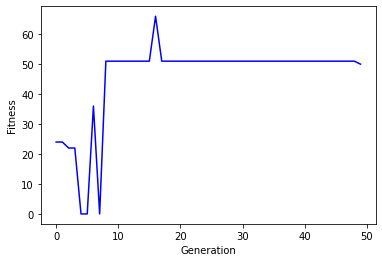

In [31]:
fig, ax = plt.subplots()
ax.plot(generation, best_adaptation, 'b')
ax.set_ylabel('Fitness')
ax.set_xlabel('Generation')
plt.show()